<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>

# <font color="steelblue">Introducción a las máquinas de vector soporte</font>

**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 05/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


## <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
#@title <b><font color="steelblue" size="+1"> Configuración de cuaderno

# Cargamos módulos
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
import math             # importamos módulo para cáculos matemáticos

# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_50_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** En este cuaderno se presenta los algoritmos basados en las máquinas de vector soporte lineales para realizar tareas de clasificación y regresión en un proceso de aprendizaje automático, con aplicaciones en diferentes situaciones con bancos de datos reales.

**Nivel de Formación:**  B

**Recomendaciones antes de usarlo:** Se requieren conocimientos básicos sobre geometría, y más concretamente sobre el trabajo con hiperplanos. 


## <font color="steelblue">Objetivos de aprendizaje</font>

* Conocer los principios matemáticos en los que se fundamenta el algoritmo de máquinas de vector soporte para tareas de clasificación o regresión en la implantación de un proceso de aprendizaje automático. 
* Determinar el clasificador de vector soporte adecuado en diferentes situaciones reales.
* Aplicar los diferentes tipos de algoritmos de SVM en tareas de clasificación y/o regresión.

## <font color="steelblue">Contenidos</font>

1. Máquinas de vector soporte
  * Clasificadores de vector soporte
  * Límite de separación entre clases no lineal
  * SVM en problemas de regresión
  * Clasificación multiclase
2. Aplicaciones
  * Problemas de clasificación
  * Problemas de regresión
3. Referencias

# <font color="steelblue">Máquinas de vector soporte</font>

Las Máquinas de Vector Soporte (Vector Support Machines, SVMs) es un algoritmo de clasificación y regresión desarrollado en la década de los 90. Aunque inicialmente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión. SVMs ha resultado ser uno de los mejores clasificadores para un amplio abanico de situaciones, por lo que se considera uno de los referentes dentro del ámbito del aprendizaje automático.

Las Máquinas de Vector Soporte se fundamentan en los clasificadores marginales maximales que se obtienen a partir del concepto matemático de hiperplano. Por ese motivo, para comprender el funcionamiento de los SVM se requieren conocimientos más profundos de algebra lineal y optimización de los utilizados hasta ahora. En estos cuadernos no se está interesado en los aspectos formales más matemáticos y por ello se recomienda el libro [Support Vector Machines Succinctly](https://www.syncfusion.com/succinctly-free-ebooks/support-vector-machines-succinctly) by Alexandre Kowalczyk para indagar más. 

## <font color="steelblue">Clasificadores de vector soporte (Support Vector Classifier)</font>




En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones  $𝑝−1$ . El término afín significa que el subespacio no tiene por qué pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de una dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones  $𝑝>3$  no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con  $𝑝−1$  dimensiones se mantiene.


Para mostrar el uso de los hiperplanos tomamos un ejemplo muy sencillo de un problema de clasificación con dos clases en dos dimensiones cuyos puntos vienen dados por:


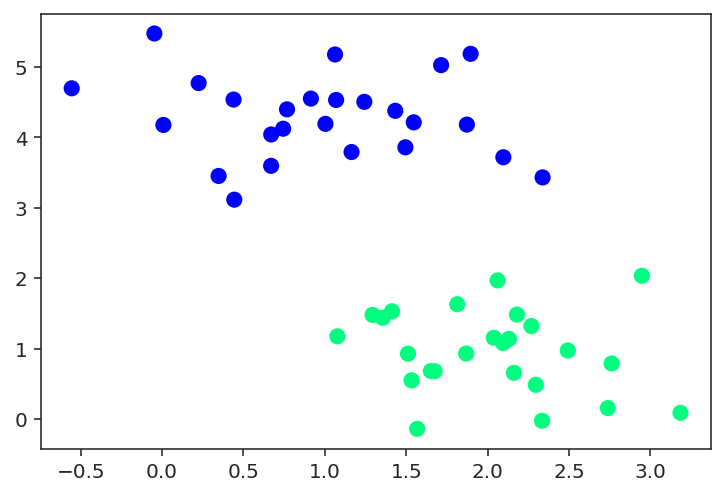

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

### <font color="steelblue">Casos separables linealmente</font>

Si la distribución de las observaciones es tal que se pueden separar linealmente de forma perfecta en las dos clases, entonces, la definición matemática de un hiperplano es bastante simple. En el caso de dos dimensiones, el hiperplano se describe acorde a la ecuación de una recta:

$$\beta_0+\beta_1𝑥_1+\beta_2𝑥_2=0$$

Dados los parámetros  $\beta_0$ ,  $\beta_1$  y  $\beta_2$, todos los pares de valores  $𝐱=(𝑥_1,𝑥_2)$  para los que se cumple la igualdad son puntos del hiperplano. Esta ecuación puede generalizarse para p-dimensiones:

$$\beta_0+\beta_1𝑥_1+\beta_2𝑥_2 +...+\beta_px_p=0$$

y de igual manera, todos los puntos definidos por el vector  $(𝐱=𝑥_1,𝑥_2,...,𝑥_𝑝)$  que cumplen la ecuación pertenecen al hiperplano.

Cuando  $𝐱$  no satisface la ecuación:

$$\beta_0+\beta_1𝑥_1+\beta_2𝑥_2 +...+\beta_px_p < 0$$
 
o bien

$$\beta_0+\beta_1𝑥_1+\beta_2𝑥_2 +...+\beta_px_p > 0$$

el punto  $𝐱$  cae a un lado o al otro del hiperplano. Así pues, se puede entender que un hiperplano divide un espacio p-dimensional en dos mitades. Para saber en qué lado del hiperplano se encuentra un determinado punto  $𝐱$, solo hay que calcular el signo de la ecuación.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo. En este problema podemos considerar diferentes hiperplanos (en este caso rectas) que nos permiten clasificar la muestra de datos de forma adecuada como podemos ver en el gráfico siguiente:

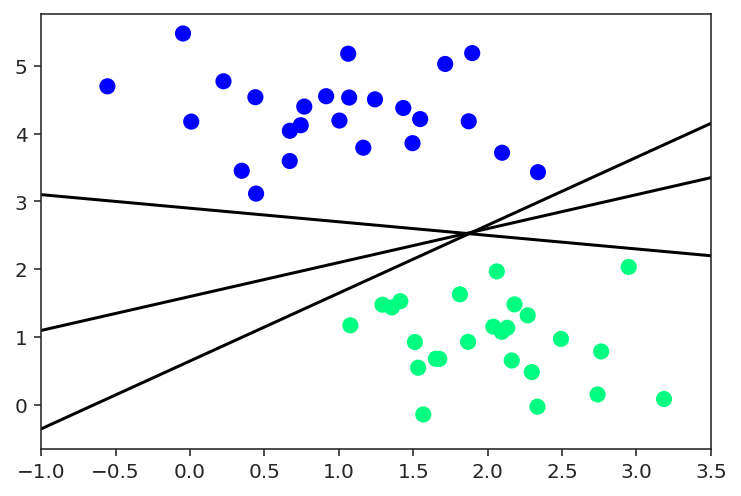

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5);

Tenemos tres rectas y posibles soluciones al problema planteado. La solución a este problema consiste en seleccionar como clasificador óptimo el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. A este se le conoce como como maximal margin hyperplane o hiperplano óptimo de separación. Para identificarlo, se tiene que calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cuán alejado está el hiperplano de las observaciones de entrenamiento. Así pues, el maximal margin hyperplane se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. El código siguiente se muestra únicamente para ver el resultado del clasificador obtenido. Más adelante se verá con todo detalle las funciones necesarias para la obtención del SVM.

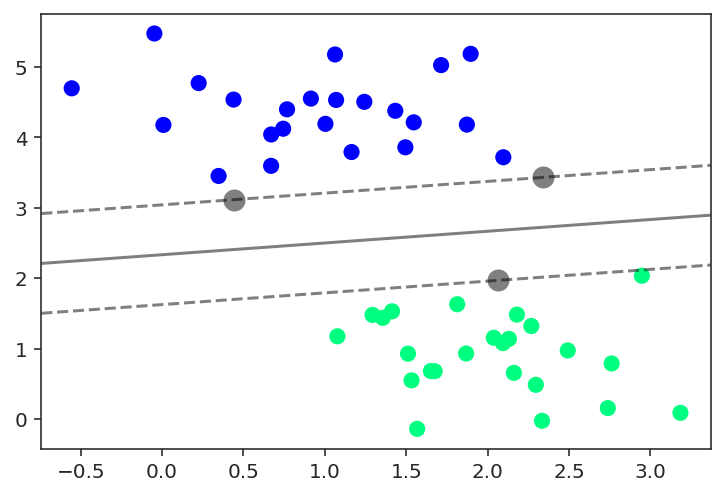

In [ ]:
# Ajuste SVM
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

# Definición para representación gráfica
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=1, facecolors='grey');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Solución obtenida
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(model);    

La imagen anterior muestra el maximal margin hyperplane, formado por el hiperplano (línea negra continua y su margen, las dos líneas discontinuas). Las tres observaciones equidistantes respecto al maximal margin hyperplane que se encuentran a lo largo de las líneas discontinuas se les conoce como vectores de soporte, ya que son vectores en un espacio p-dimensional y soportan (definen) el maximal margin hyperplane. Cualquier modificación en estas observaciones (vectores soporte) conlleva cambios en el maximal margin hyperplane. Sin embargo, modificaciones en observaciones que no son vector soporte no tienen impacto alguno en el hiperplano.

### <font color="steelblue">Casos no separables linealmente</font>

El maximal margin hyperplane descrito en el apartado anterior es una forma muy simple y natural de clasificación siempre y cuando exista un hiperplano de separación. En la gran mayoría de casos reales, los datos no se pueden separar linealmente de forma perfecta, por lo que no existe un hiperplano de separación y no puede obtenerse un maximal margin hyperplane. Para el siguiente ejemplo se emplea un set de datos publicado en el libro Elements of Statistical Learning que contiene observaciones simuladas con una función no lineal en un espacio de dos dimensiones (2 predictores). El objetivo es entrenar un modelo SVM capaz de clasificar las observaciones.

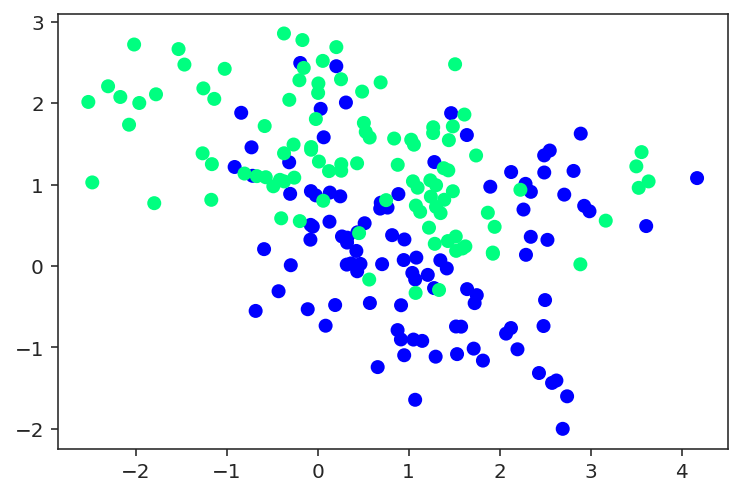

In [ ]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/ESL.mixture.csv'
datos = pd.read_csv(url)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(datos.X1, datos.X2, c=datos.y,cmap='winter');

Para solucionar estas situaciones, se puede extender el concepto de maximal margin hyperplane para obtener un hiperplano que "casi" separe las clases, pero permitiendo que se cometan unos pocos errores. A este tipo de hiperplano se le conoce como Support Vector Classifier o Soft Margin.

### <font color="steelblue">Soft Margin SVM</font>

El Maximal Margin Classifier descrito en la sección anterior tiene poca aplicación práctica, ya que rara vez se encuentran casos en los que las clases sean perfecta y linealmente separables. De hecho, incluso cumpliéndose estas condiciones ideales, en las que exista un hiperplano capaz de separar perfectamente las observaciones en dos clases, esta aproximación sigue presentando dos inconvenientes:

* Dado que el hiperplano tiene que separar perfectamente las observaciones, es muy sensible a variaciones en los datos. Incluir una nueva observación puede suponer cambios muy grandes en el hiperplano de separación (poca robustez).

* Que el maximal margin hyperplane se ajuste perfectamente a las observaciones de entrenamiento para separarlas todas correctamente suele conllevar problemas de overfitting.

Por estas razones, es preferible crear un clasificador basado en un hiperplano que, aunque no separe perfectamente las dos clases, sea más robusto y tenga mayor capacidad predictiva al aplicarlo a nuevas observaciones (menos problemas de overfitting). Esto es exactamente lo que consiguen los clasificadores de vector soporte, también conocidos como soft margin classifiers o Support Vector Classifiers. Para lograrlo, en lugar de buscar el margen de clasificación más ancho posible que consigue que las observaciones estén en el lado correcto del margen; se permite que ciertas observaciones estén en el lado incorrecto del margen o incluso del hiperplano.

La identificación del hiperplano que clasifique correctamente la mayoría de las observaciones a excepción de unas pocas, es un problema de optimización convexa. Si bien la demostración matemática queda fuera del objetivo de esta introducción, es importante mencionar que el proceso incluye un hiperparámetro llamado  𝐶 .  𝐶  controla el número y severidad de las violaciones del margen (y del hiperplano) que se toleran en el proceso de ajuste. Si  𝐶=∞ , no se permite ninguna violación del margen y por lo tanto, el resultado es equivalente al Maximal Margin Classifier (teniendo en cuenta que esta solución solo es posible si las clases son perfectamente separables). Cuando más se aproxima  𝐶  a cero, menos se penalizan los errores y más observaciones pueden estar en el lado incorrecto del margen o incluso del hiperplano.  𝐶  es, a fin de cuentas, el hiperparámetro encargado de controlar el balance entre bias y varianza del modelo. En la práctica, su valor óptimo se identifica mediante validación cruzada.

El proceso de optimización tiene la peculiaridad de que solo las observaciones que se encuentran justo en el margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte y son las que definen el clasificador obtenido. Esta es la razón por la que el parámetro  𝐶  controla el balance entre bias y varianza. Cuando el valor de  𝐶  es pequeño, el margen es más ancho, y más observaciones violan el margen, convirtiéndose en vectores soporte. El hiperplano está, por lo tanto, sustentado por más observaciones, lo que aumenta el bias pero reduce la varianza. Cuando mayor es el valor de  𝐶 , menor el margen, menos observaciones son vectores soporte y el clasificador resultante tiene menor bias pero mayor varianza.

Otra propiedad importante que deriva de que el hiperplano dependa únicamente de una pequeña proporción de observaciones (vectores soporte), es su robustez frente a observaciones muy alejadas del hiperplano. 

## <font color="steelblue">Límite de separación entre clases no lineal</font>

El Support Vector Classifier descrito en los apartados anteriores consigue buenos resultados cuando el límite de separación entre clases es aproximadamente lineal. Si no lo es, su capacidad decae drásticamente. Una estrategia para enfrentarse a escenarios en los que la separación de los grupos es de tipo no lineal consiste en expandir las dimensiones del espacio original.

El hecho de que los grupos no sean linealmente separables en el espacio original no significa que no lo sean en un espacio de mayores dimensiones. Las imágenes siguientes muestran dos grupos cuya separación en dos dimensiones no es lineal, pero sí lo es al añadir una tercera dimensión.

<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/SVM_01.png width="450" height="400"></small>

El método de Máquinas Vector Soporte (SVM) se puede considerar como una extensión del Support Vector Classifier obtenida al aumentar la dimensión de los datos. Los límites de separación lineales generados en el espacio aumentado se convierten en límites de separación no lineales al proyectarlos en el espacio original. Este algortimo se estudiará con detalle en el cuaderno siguiente, ya que por el momento nos centramos en la aplicación del Support Vector Classifier en problemas de clasificación y regresión.

## <font color="steelblue">SVM en problemas de regresión (SVR)</font>

Las máquinas de vectores soporte (SVM) son bien conocidas en problemas de clasificación. Sin embargo, el uso de SVM en regresión no está tan bien documentado. Este tipo de modelos se conoce como regresión de vectores de soporte (SVR).

En la mayoría de los modelos de regresión lineal, el objetivo es minimizar la suma de errores al cuadrado. Tomemos como ejemplo los mínimos cuadrados ordinarios (MCO). La función objetivo para MCO con un predictor (característica) es la siguiente:

$$\underset{\beta}{min} \sum_{i=1}^n (y_i-\beta x_i)^2.$$

Lasso, Ridge y ElasticNet son extensiones de esta sencilla ecuación, con un parámetro de penalización adicional que pretende minimizar la complejidad y/o reducir el número de características utilizadas en el modelo final. En cualquier caso, el objetivo -como ocurre con muchos modelos- es reducir el error del conjunto de pruebas.

Sin embargo, ¿qué ocurre si sólo nos preocupa reducir el error hasta cierto punto? ¿Y si no nos importa lo grandes que sean nuestros errores, siempre que estén dentro de un rango aceptable?

SVR nos da la flexibilidad de definir cuánto error es aceptable en nuestro modelo y encontrar una línea adecuada (o hiperplano en dimensiones superiores) para ajustarse a los datos.

En contraste con OLS, la función objetivo de SVR se encarga de minimizar los coeficientes - más específicamente, la norma l2 del vector de coeficientes - no el error al cuadrado. El término de error se maneja en las restricciones, donde se establece el error absoluto menor o igual a un margen especificado, llamado el error máximo, $\epsilon$. Podemos ajustar epsilon para obtener la precisión deseada de nuestro modelo. Nuestra nueva función objetivo y las restricciones son las siguientes:

$$\text{Función: }\underset{\beta}{min} \quad \frac{1}{2} ||\mathbf{\beta}||^2 $$

$$\text{Restricción: } |y_i-\beta x_i| \leq \epsilon$$

<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/SVM_02.png width="550" height="300"></small>

Este algoritmo no está exento de problemas ya que aunque se resuelve la función objetivo algunos de los puntos siguen quedando fuera de los márgenes establecidos. Como tal, tenemos que tener en cuenta la posibilidad de errores que sean mayores que $\epsilon$. Esto se hace introduciendo variables de holgura.

El concepto de variables de holgura es sencillo: para cualquier valor que quede fuera de $\epsilon$, podemos denotar su desviación del margen como $\xi$. Sabemos que estas desviaciones pueden existir, pero aun así nos gustaría minimizarlas en la medida de lo posible. Por lo tanto, podemos añadir estas desviaciones a la función objetivo:

$$\text{Función: }\underset{\beta}{min} \quad \frac{1}{2} ||\mathbf{\beta}||^2 + C \sum_{i=1}^n |\xi|$$

$$\text{Restricción: } |y_i-\beta x_i| \leq \epsilon + |\xi|$$




<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/SVM_03.png width="550" height="300"></small>

Ahora tenemos un hiperparámetro adicional, C, que podemos ajustar. A medida que C aumenta, nuestra tolerancia para los puntos fuera de ϵ también aumenta. A medida que C se acerca a 0, la tolerancia se aproxima a 0 y la ecuación colapsa en la simplificada (aunque a veces inviable).

## <font color="steelblue">Clasificación multiclase</font>

El concepto de hiperplano de separación en el que se basan los SVMs no se generaliza de forma natural para más de dos clases. Se han desarrollado numerosas estrategias con el fin de aplicar este algoritmo a problemas multiclase, de entre ellos, los más empleados son: one-versus-one, one-versus-all y DAGSVM.


**One-versus-one**


Supóngase un escenario en el que hay K > 2 clases y que se quiere aplicar el método de clasificación basado en SVMs. La estrategia de one-versus-one consiste en generar un total de K(K-1)/2 SVMs, comparando todos los posibles pares de clases. Para generar una predicción, se emplean cada uno de los K(K-1)/2 clasificadores, registrando el número de veces que la observación es asignada a cada una de las clases. Finalmente, se considera que la observación pertenece a la clase a la que ha sido asignada con más frecuencia. La principal desventaja de esta estrategia es que el número de modelos necesarios se dispara a medida que aumenta el número de clases, por lo que no es aplicable en todos los escenarios.


**One-versus-all**


Esta estrategia consiste en ajustar K SVMs distintos, cada uno comparando una de las K clases frente a las restantes K-1 clases. Como resultado, se obtiene un hiperplano de clasificación para cada clase. Para obtener una predicción, se emplean cada uno de los K clasificadores y se asigna la observación a la clase para la que la predicción resulte positiva. Esta aproximación, aunque sencilla, puede causar inconsistencias, ya que puede ocurrir que más de un clasificador resulte positivo, asignando así una misma observación a diferentes clases. Otro inconveniente adicional es que cada clasificador se entrena de forma no balanceada. Por ejemplo, si el set de datos contiene 100 clases con 10 observaciones por clase, cada clasificador se ajusta con 10 observaciones positivas y 990 negativas.


**DAGSVM**


DAGSVM (Directed Acyclic Graph SVM) es una mejora del método one-versus-one. La estrategia seguida es la misma, pero consiguen reducir su tiempo de ejecución eliminando comparaciones innecesarias gracias al empleo de una directed acyclic graph (DAG). Supóngase un set de datos con cuatro clases (A, B, C, D) y 6 clasificadores entrenados con cada posible par de clases (A-B, A-C, A-D, B-C B-D, C-D). Se inician las comparaciones con el clasificador (A-D) y se obtiene como resultado que la observación pertenece a la clase A, o lo que es equivalente, que no pertenece a la clase D. Con esta información se pueden excluir todas las comparaciones que contengan la clase D, puesto que se sabe que no pertenece a este grupo. En la siguiente comparación se emplea el clasificador (A-C) y se predice que es A. Con esta nueva información se excluyen todas las comparaciones que contengan C. Finalmente solo queda emplear el clasificador (A-B) y asignar la observación al resultado devuelto. Siguiendo esta estrategia, en lugar de emplear los 6 clasificadores, solo ha sido necesario emplear 3. DAGSVM tiene las mismas ventajas que el método one-versus-one pero mejorando mucho el rendimiento.

# <font color="steelblue">SVM lineal en python</font>

En `scikit-learn` la clase `sklearn.svm.LinearSVC` permite utilizar el algoritmo SVM de clasificación lineal, mientras que `sklearn.svm.LinearSVR` utiliza el algoritmo SVM lineal para problemas de regresión. 

Los parámetros más relevantes para la clase `sklearn.svm.LinearSVC` son:

* **penalty: {‘l1’, ‘l2’}, default=’l2’**. Especifica la norma utilizada en la penalización. La penalización 'l2' es la norma utilizada en SVC. El 'l1' conduce a vectores coef_ que son dispersos.

* **loss: {‘hinge’, ‘squared_hinge’}, default=’squared_hinge’**. Especifica la función de pérdida. `hinge` es la pérdida SVM estándar (utilizada, por ejemplo, por la clase SVC), mientras que `squared_hinge` es el cuadrado de la pérdida hinge. No se admite la combinación de penalty='l1' y loss='hinge'.

* **dual: bool, default=True**. Selecciona el algoritmo para resolver el problema de optimización dual o primal. Configuramos 'dual=False' cuando n_muestras > n_características.

* **C: float, default=1.0**. Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C. Debe ser estrictamente positivo.

* **multi_class: {‘ovr’, ‘crammer_singer’}, default=’ovr’**. Determina la estrategia multiclase si `y` contiene más de dos clases. "ovr" entrena n_clases con clasificadores de una contra el resto, mientras que "crammer_singer" optimiza un objetivo conjunto para todas las clases. Aunque "crammer_singer" es interesante desde un punto de vista teórico, ya que es coherente, en la práctica se utiliza muy poco, ya que rara vez mejora la precisión y es más caro de calcular. Si se elige "crammer_singer", se ignorarán las opciones penalty, loss y dual.

Los parámetros más relevantes para la clase `sklearn.svm.LinearSVR` son:

* **epsilon: float, default=0.0**. Parámetro épsilon en la función de pérdida insensible a épsilon. Hay que tener en cuenta que el valor de este parámetro depende de la escala de la variable objetivo. Si no estás seguro, establece epsilon=0.

* **loss: {‘epsilon_insensitive’, ‘squared_epsilon_insensitive’}, default=’epsilon_insensitive’**. Especifica la función de pérdida. La pérdida insensible a épsilon (SVR estándar) es la pérdida L1, mientras que la pérdida insensible a épsilon al cuadrado ('squared_epsilon_insensitive') es la pérdida L2.

* **dual: bool, default=True**. Selecciona el algoritmo para resolver el problema de optimización dual o primal. Configuramos 'dual=False' cuando n_muestras > n_características.

* **C: float, default=1.0**. Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C. Debe ser estrictamente positivo.

# <font color="steelblue">Aplicaciones</font>

En este cuaderno se muestran diferentes ejemplos para entender el funcionamiento de los SVM lineales tanto en problemas de clasificación binaria o multiclase, y problemas de regresión. Cargamos las clases necesarias:

In [ ]:
# SVM para clasificación
from sklearn.svm import LinearSVC
# SVM para regresión
from sklearn.svm import LinearSVR
# Modulos 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_squared_error
import multiprocessing

## <font color="steelblue">Problemas de clasificación</font>

Comenzamos con los problemas de clasificación binaria y posteriormente veremos los de clasificación multiclase. En concreto utilizaremos dos predictoras para poder representar gráficamente la solución obtenida.



### Datos de mixturas

Recuperamos el conjunto de datos sobre mixturas presentado anteriormente. Dividimos en muestra de entrenamiento y validación, y ajustamos un modelo de partida básico fijando C=100.

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns = 'y')
y = datos['y']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Ajuste del modelo
# ==============================================================================
modelo = LinearSVC(C = 100, random_state=123, dual=False)
modelo.fit(X_train, y_train.ravel())

LinearSVC(C=100, dual=False, random_state=123)

Antes de ver las métricas de validación del modelo propuesto analizamos gráficamente la solución obtenida. Para ello vamos a hacer uso de la librería `mlxtend`. En concreto usaremos la función `plot_decision_regions` para representar en un espacio de dos dimensiones el resultado de un clasificador. En primer lugar instalamos la librería y cargamos el módulo gráfico

In [ ]:
! pip install mlxtend --upgrade --no-deps
from mlxtend.plotting import plot_decision_regions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


Ahora representamos las regiones de clasificación determinadas por el hiperplano lineal.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


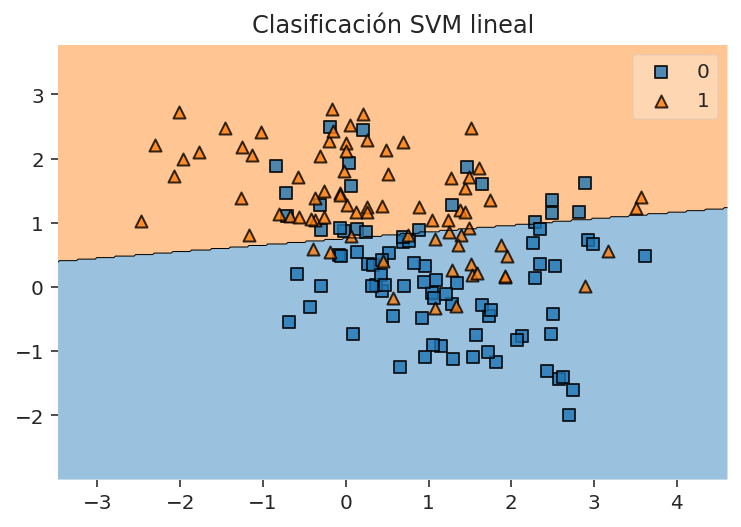

In [ ]:
# Representación gráfica utilizando plot_decision_regions() de mlxtend
# ==============================================================================
fig, ax = plt.subplots(figsize=(6,4))
plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.flatten(),
    clf = modelo,
    ax = ax
)
ax.set_title("Clasificación SVM lineal");

Obtenemos la exactitud de la muestra de validación para este modelo

In [ ]:
# Predicción de la clasificación
predicciones = modelo.predict(X_test)
# Exactitud
accuracy_score(y_true = y_test, y_pred = predicciones)

0.675

Obtenemos un porcentaje de clasificación correcta del 67.5% que no se considera muy bueno. De hecho, gráficamente se puede ver la gran mezcla existente entre ambas clases lo que hace imposible que un clasficador lineal obtenga buenos resultados. En el cuaderno siguiente se mostrarán los clasificadores no lineales pero por el momento vamos a tratar de obtener una mejor solución lineal haciendo una búsqueda del parámetro C. Para ellos utilizamos grid search como en ocasiones anteriores. 

In [ ]:
# Rango de valores de C: Tomamos 50 valores en el rango 1-1000
parameters = {"C": range(1, 1001, 50)}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVC(dual = False), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train, y_train.ravel())
# Solución óptima
gridsearch.best_params_

{'C': 1}

El óptimo del algortimo se alcanza para C=1. Evaluamos la exactitud en esa situación.

In [ ]:
# Predicción de la clasificación
predicciones = gridsearch.predict(X_test)
# Exactitud
accuracy_score(y_true = y_test, y_pred = predicciones)

0.675

La exactitud obtenida es idéntica indicando que la elección de C en este caso no es relevante dado que la separación entre las clases no es lineal. Por último obtenemos la matriz de confusión asociada a este problema de clasificación

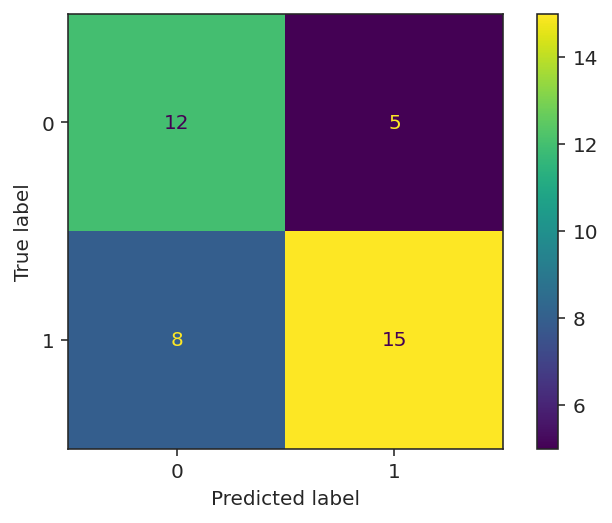

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, predicciones, labels = gridsearch.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gridsearch.classes_)
# Representamos
disp.plot();

Podemos ver que hay un mayor error en la clasificación de las muestras que originalmente estaban etiquetadas como 1 (8/23) frente a las etiquetadas como 0 (5/17).

### Breast cancer in Wisconsin

Con la información recogida sobre los cánceres de mama en la ciudad de Wisconsin queremos clasificar un tumor como benigno o maligno. Cargamos la base de datos ya preprocesada y ajustamos una SVM lineal para el problema de clasificación binaria.

In [ ]:
# Breast Cancer Wisconsin
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/cancer_clean.csv'
cancer = pd.read_csv(url, index_col=0)
# objetivo
y_cancer = cancer['diagnosis']
# matriz de características
X_cancer = cancer.drop(columns=['diagnosis'])

# División de muestras
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.3, random_state=0)

Procedemos ahora con el ajuste del modelo buscando el C óptimo como en el caso anterior. En lugar de probar un rango de valores vamos a probar una secuencia específica de valores de C.

In [ ]:
# Rango de valores de C: Tomamos 50 valores en el rango 1-1000
parameters = {"C": [0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVC(dual = False, max_iter = 5000), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train_cancer, y_train_cancer.ravel())
# Solución óptima
gridsearch.best_params_

{'C': 0.1}

El óptimo se alcanza para C=0.1. En este caso no resulta posible representar gráficamente la solución ya que disponemos de más de dos predictoras. Obtenemos la exactitud y la tabla de confusión correspondiente con este modelo.

In [ ]:
# Predicción de la clasificación
predicciones = gridsearch.predict(X_test_cancer)
# Exactitud
np.round(accuracy_score(y_true = y_test_cancer, y_pred = predicciones),3)

0.965

A pesar de que la solución lineal no puede resultar adecuada la exactitud obtenida se sitúa en el 96.5% que es un porcentaje muy alto. Veamos la tabla de confusión:

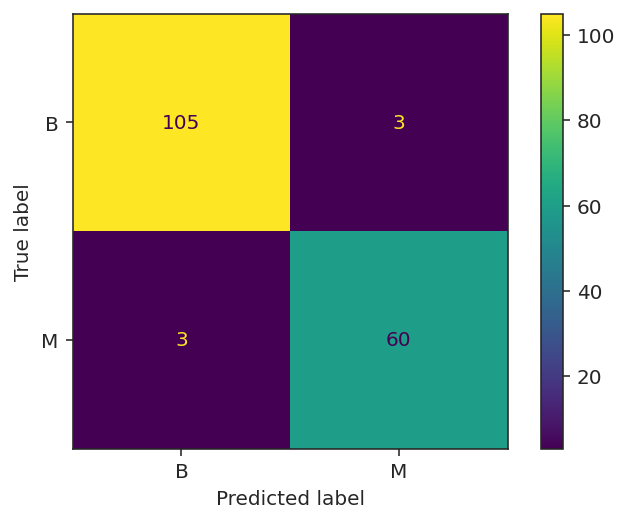

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_cancer, predicciones, labels = gridsearch.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gridsearch.classes_)
# Representamos
disp.plot();

Se puede ver que sólo se producen tres errores de clasificación respecto de la etiqueta original en ambas clases. Esta exactitud es algo mejor que la que obteníamos para este mismo banco de datos utilizando k-NN.

### Iris dataset

Este banco de datos lo hemos utilizado anteriormente y se trata de clasificar tres tipos de flores en función de las longitudes y anchuras de pétalo y sépalo. Se trata pues de un problema multiclase. Para poder representar gráficamente la solución obtenida vamos a utilizar como predictoras  la longitud y anchura de sépalo. En primer lugar cargamos los datos y los preparamos para la construcción del algoritmo.

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

Dividimos en muestra de entrenamiento y validación

In [ ]:
# División de muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Ajustamos el modelo variando el valor de C.

In [ ]:
# Rango de valores de C: Tomamos 50 valores en el rango 1-1000
parameters = {"C": [0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVC(dual = False, max_iter = 5000), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train, y_train.ravel())
# Solución óptima
gridsearch.best_params_

{'C': 10}

En este caso el óptimo se alcanza para C=10 indicando que en este caso la regularización si tiene efecto sobre la solución. Podemos ver la solución obtenida mediante el gráfico de regiones de clasifiación. 

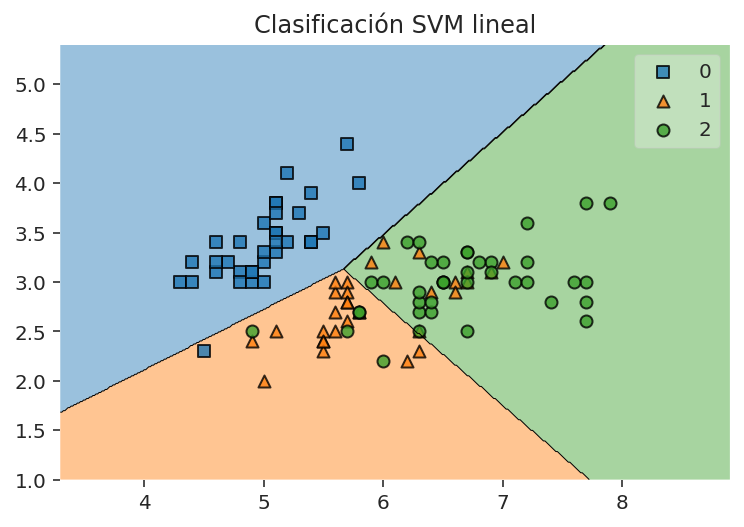

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
plot_decision_regions(
    X = X_train,
    y = y_train,
    clf = gridsearch,
    ax = ax
)
ax.set_title("Clasificación SVM lineal");

En el gráfico se pueden ver claramente las tres regiones que identifica el algoritmo. En cada una de ellas se aprecia notablemente una mayoría de elementos etiquetados de una clase, pero también podemos ver ciertos errores en la clasificación. Analizamos los resultados obtenidos. En primer lugar obtenemos la exactitud del algoritmo.

In [ ]:
# Predicción de la clasificación
predicciones = gridsearch.predict(X_test)
# Exactitud
np.round(accuracy_score(y_true = y_test, y_pred = predicciones),3)

0.689

A pesar de usar sólo dos de las cuatro posibles predictoras el porcentaje de clasificación correcto es del 68.9%. Analizamos la tabla de confusión y el informe completo de clasificación.

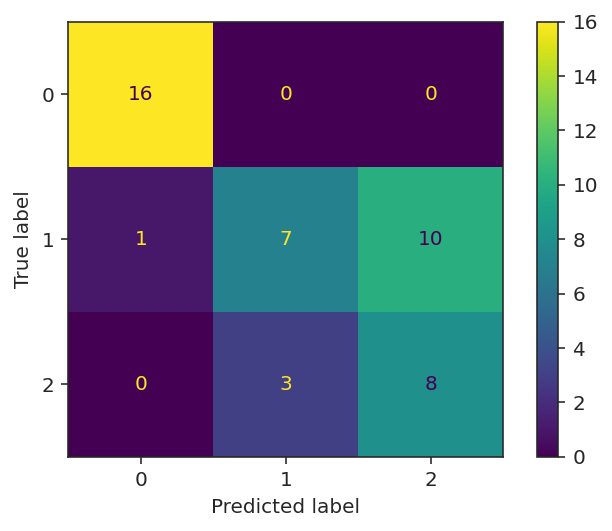

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, predicciones, labels = gridsearch.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gridsearch.classes_)
# Representamos
disp.plot();

Podemos ver que la etiqueta 0 tiene una clasificación perfecta, mientras que la etiqueta 1 es sobre la que se observan mayores errores de clasficación. Analizamos los porcentajes a través del informe de clasificación 

In [ ]:
print(classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.70      0.39      0.50        18
           2       0.44      0.73      0.55        11

    accuracy                           0.69        45
   macro avg       0.70      0.71      0.67        45
weighted avg       0.72      0.69      0.68        45



En la columna 'recall' podemos ver los porcentajes de clasificación correcta dentro de cada etiqueta, y el global para todo el conjunto de datos. Si consideráramos todas las predictoras podríamos ver que el algortimo tiene un porcentaje de clasificación correcta del 100%.

### Abalone

En este ejemplo, se recoge información sobre los abulones. Se está interesado en medir su desarrollo que viene determinado principalmnete por su desarrollo sexual. Concretamente se consideran tres estados de desarrollo (asociados con la varaible sex): M (machos), F (hembras), e I (infantil o sin desarrollo sexual). Aunque el banco de datos no contiene valores perdidos es necesario estandarizar los datos antes de construir el algoritmo de clasificación basado en SVM.

In [ ]:
# Lectura de datos
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/abalone.csv'
abalone = pd.read_csv(url)
# Preparamos datos
X_abalone = abalone.drop(columns='Sex')
y_abalone = abalone['Sex'].astype('category')
# Estandarizamos datos
sc = StandardScaler()
X_abalone_std = sc.fit_transform(X_abalone)

Dividimos en conjunto en entrenamiento y validación.

In [ ]:
# División de muestras estandarizadas
X_train_abalone, X_test_abalone, y_train_abalone, y_test_abalone = train_test_split(X_abalone_std, y_abalone, test_size=0.20, random_state=0)

Ajustamos ahora el modelo

In [ ]:
# Rango de valores de C: Tomamos 50 valores en el rango 1-1000
parameters = {"C": [0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVC(dual = False, max_iter = 5000), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train_abalone, y_train_abalone.ravel())
# Solución óptima
gridsearch.best_params_

{'C': 10}

De nuevo obtenemos el valor de C=10. Analizamos con detalle la clasificación obtenida.

In [ ]:
# Predicción de la clasificación
predicciones = gridsearch.predict(X_test_abalone)
# Exactitud
np.round(accuracy_score(y_true = y_test_abalone, y_pred = predicciones),3)

0.548

La exactitud obtenida es tan solo del 54.8% indicando que el modelo no resulta muy adecuado para clasificar entre las tres etiquetas consideradas. Analizamos la matriz de confusión y el informe de clasificación completo.

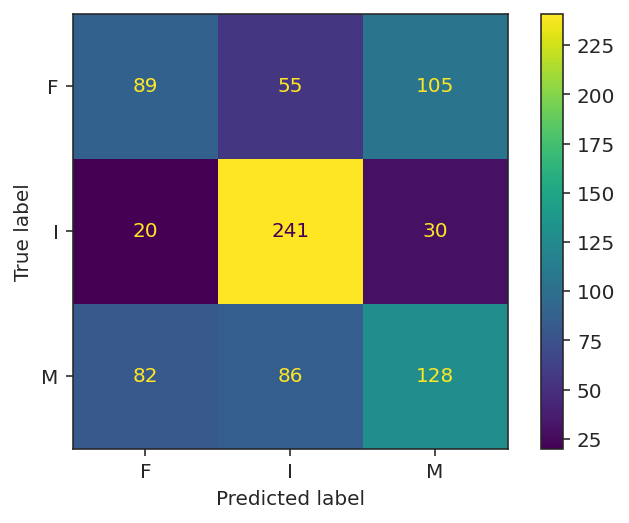

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_abalone, predicciones, labels = gridsearch.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gridsearch.classes_)
# Representamos
disp.plot();

Como ya hemos podido ver con otros algoritmos de clasifiación sobre este mismo conjunto de datos la matriz de confusión nos indica claramente que hay una gran mezcla entre las tres etiquetas indicando que las predictoras no parecen ser adecuadas para distinguir entre ellas. En el informe completo podemos ver los porcentajes de error cometidos con cada etiqueta.

In [ ]:
print(classification_report(y_test_abalone, predicciones))

              precision    recall  f1-score   support

           F       0.47      0.36      0.40       249
           I       0.63      0.83      0.72       291
           M       0.49      0.43      0.46       296

    accuracy                           0.55       836
   macro avg       0.53      0.54      0.53       836
weighted avg       0.53      0.55      0.53       836



El mayor error se comete con la etiqueta "F" donde solo clasificamos correctamente el 36% de los casos. La etiqueta con mejor porcentaje de clasificación es "I" con un 83% de aciertos. 

## <font color="steelblue">Problemas de regresión</font>

Para ejemplificar el uso de SVM lineal en problemas de regresión vamos a considerar dos ejemplos simulados y el banco de datos de precios de las viviendas en california que hemos venido utilizando en cuadernos anteriores.

### Banco de datos simulados 1

Los datos simulados corresponden con un modelo de regresión lineal simple con variabilidad del error muy pequeña.

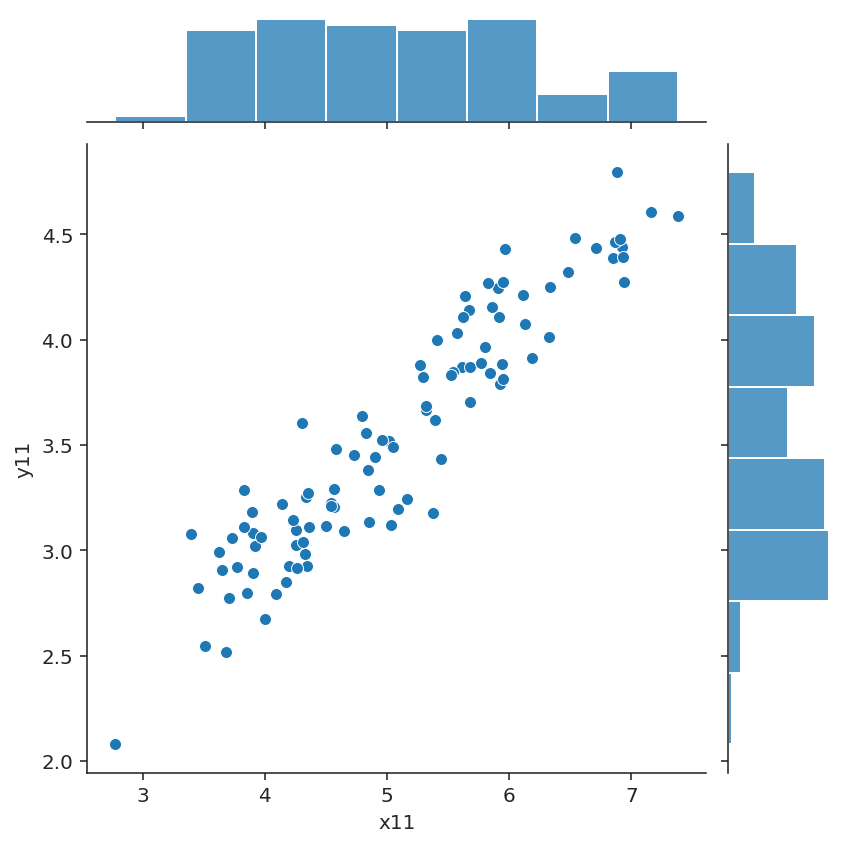

In [ ]:
# Generamos los puntos
import random
np.random.seed(0)
mu, sigma = 0, 0.2
n  = 100
error = np.random.normal(mu, sigma, n)
datos1 = pd.DataFrame()
datos1['x11'] = np.random.normal(5, 1, n)
datos1['y11'] = 1 + 0.5*datos1['x11'] + error
# Representamos gráficamente la nube de puntos obtenida
sns.jointplot(data=datos1, x="x11", y="y11");

En primer lugar usamos el algoritmo con las opciones por defecto para estudiar su comportamiento. Para ello extraemos la matriz $X$ y el vector $y$, estandarizamos y dividimos en muestra de entrenamiento y validación. 

In [ ]:
# División de los datos en train y test
# ==============================================================================
# Como sólo tenemos una predictora debemos convertir a array y redimensionar la matriz X
X = datos1['x11'].to_numpy().reshape(-1, 1)
y = datos1['y11'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.7,
                                        random_state = 1234
                                    )

# Ajuste del modelo
# ==============================================================================
modelo = LinearSVR(random_state=123, dual = False, loss = "squared_epsilon_insensitive")
modelo.fit(X_train, y_train)

LinearSVR(dual=False, loss='squared_epsilon_insensitive', random_state=123)

Obtenemos el coeficiente asociado a la predictora para compararlo con el valor real.

In [ ]:
modelo.coef_

array([0.55604644])

El coeficiente obtenido con el algoritmo es muy similar al valor real de la muestra de simulación por lo que esperamos que las medidas de calidad del ajuste sean muy buenas. En concreto obtenemos el valor del $R^2$ y el RMSE para la muestra de validación.

In [ ]:
# Predicciones del modelo
predicciones = modelo.predict(X_test)
# Medidas de calidad del modelo propuesto
print('El valor del R2 es: %.2f'%modelo.score(X_test, y_test))
print('El valor de RMSE es: %.4f'%mean_squared_error(y_test, predicciones, squared = False))

El valor del R2 es: 0.87
El valor de RMSE es: 0.2114


Como era de esperar la solución obtenida es bastante buena lo que podemos corroborar con el gráfico de predicción correspondiente a este modelo.

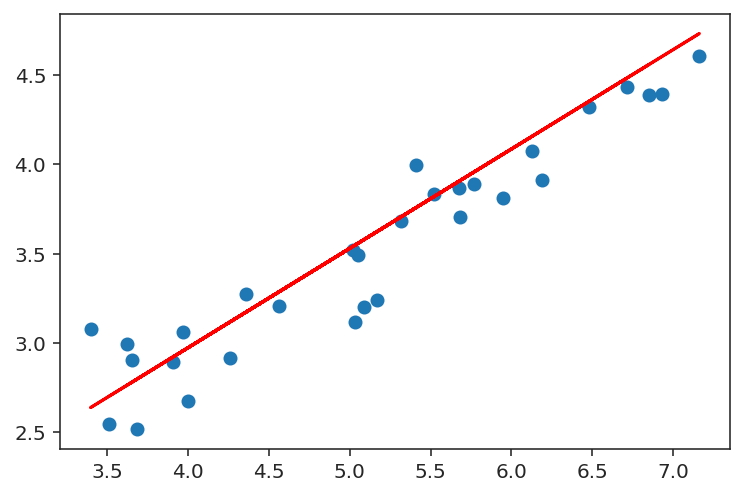

In [ ]:
# Nube de puntos original
plt.scatter(X_test, y_test) 
# Modelo predicho
plt.plot(X_test, predicciones, color ='r')   
plt.show() 

La solución obtenida reproduce bastante bien el comportamiento de los datos de validación. Procedemos ahora con el modelo óptimo mediante grid search. En este caso podemos variar $\epsilon$ y C. Establecemos una rango de valores de $\epsilon$ dentro del rango de variabilidad de la respuesta:

In [ ]:
y_train.std()

0.5701145193930308

In [ ]:
# Rango de valores de C
parameters = {"epsilon": [0, 0.1, 0.2, 0.3, 0.4],
    "C": [0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVR(dual = False, loss = "squared_epsilon_insensitive"), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train, y_train.ravel())
# Solución óptima
gridsearch.best_params_

{'C': 10000, 'epsilon': 0.1}

Los valores óptimos son C=1000 y $\epsilon$ = 0.1. Pasamos a estudiar la validez del modelo obtenido. 

In [ ]:
# Predicciones del modelo
predicciones = gridsearch.predict(X_test)
# Medidas de calidad del modelo propuesto
print('El valor del R2 es: %.2f'%gridsearch.score(X_test, y_test))
print('El valor de RMSE es: %.4f'%mean_squared_error(y_test, predicciones, squared = False))

El valor del R2 es: 0.87
El valor de RMSE es: 0.2086


La capacidad explicativa del modelo es la misma (87%) pero hemos reducido en algo el RMSE con respecto al modelo de partida. Es cierto sin embargo que dicha reducción es mínima y que podría tomarse por bueno el modelo de partida.

### Banco de datos simulados 2

Consideramos un conjunto de datos simulados similar al del ejemplo anterior pero con una mayor variabilidad en los errores, lo que se reflejará en una nube de puntos mucho más dispersa.

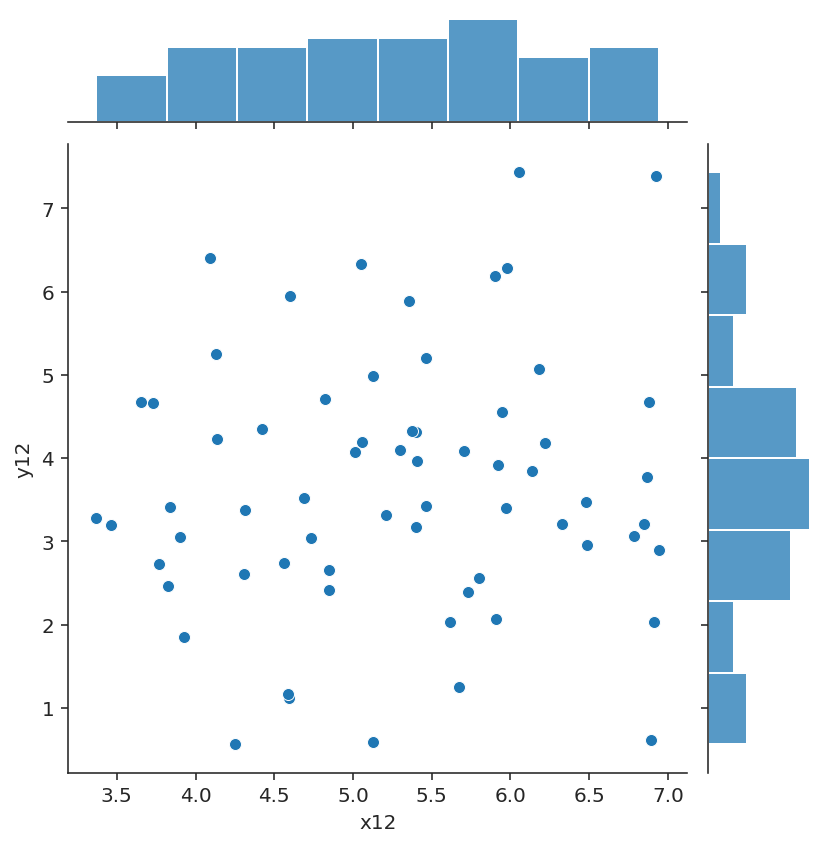

In [ ]:
# Generamos los puntos
np.random.seed(0)
mu, sigma = 0, 1.5
error = np.random.normal(mu, sigma, 65)
datos2 = pd.DataFrame()
datos2['x12'] = np.random.normal(5, 1, 65)
datos2['y12'] = 1 + 0.5*datos2['x12'] + error
# Representamos gráficamente la nube de puntos obtenida
sns.jointplot(data=datos2, x="x12", y="y12");

Preparamos los datos para el análisis. 

In [ ]:
X = datos2['x12'].to_numpy().reshape(-1, 1)
y = datos2['y12'].to_numpy()

División de muestras

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.7,
                                        random_state = 1234
                                    )

Obtenemos la variabilidad de la respuesta para fijar los valores del algoritmo de búsqueda de la solución óptima.

In [ ]:
y_train.std()

1.5368629834807719

Establecemos el algoritmo de búsqueda

In [ ]:
# Rango de valores de C
parameters = {"epsilon": [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4],
    "C": [0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVR(dual = False, loss = "squared_epsilon_insensitive"), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train, y_train.ravel())
# Solución óptima
gridsearch.best_params_

{'C': 1, 'epsilon': 0}

En este caso los valores óptimos nos indican que no hay corrección para $\epsilon$ mientras que se establece una regularización de C=1. Estudiamos la solución obtenida.

In [ ]:
# Predicciones del modelo
predicciones = gridsearch.predict(X_test)
# Medidas de calidad del modelo propuesto
print('El valor del R2 es: %.2f'%gridsearch.score(X_test, y_test))
print('El valor de RMSE es: %.4f'%mean_squared_error(y_test, predicciones, squared = False))

El valor del R2 es: -0.17
El valor de RMSE es: 1.6555


El valor de $R^2$ negativo ya es una clara indicación de que el modelo propuesto tiene una capacidad explicativa muy baja. De hecho el error de predicción es muy próximo al valor de la variabilidad de la respuesta en la muestra de entrenamiento. Podemos ver la solución gráfica correspondiente:

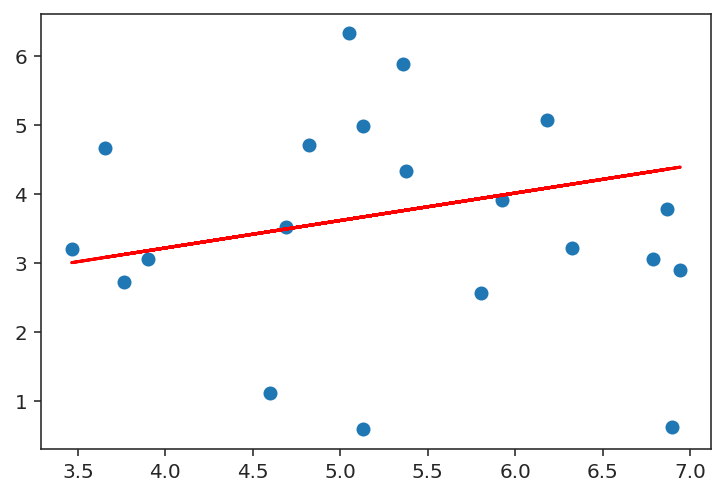

In [ ]:
# Nube de puntos original
plt.scatter(X_test, y_test) 
# Modelo predicho
plt.plot(X_test, predicciones, color ='r')   
plt.show() 

Se observa la gran dispersión de la nube de puntos respecto del modelo propuesto, lo que provoca un gran error de predicción.

### Diabetes

En este estudio sobre la diabetes el objetivo es obtener una medida cuantitativa de la progresión de la enfermedad un año después de la línea de base. Como todas las variables de la base de datos son numéricas llevaremos a cabo un ajuste de regresión. 

La base de datos se obtiene del repositorio de scikit-learn y todos los detalles se pueden consultar en este [enlace](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

La información ya viene pretratada (tratamiento de valores perdidos y estandarización), pero se cargan por separado las predictoras y la respuesta.

In [ ]:
# Carga de datos diabetes
from sklearn.datasets import load_diabetes
X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_diabetes_df = pd.DataFrame(X_diabetes)
y_diabetes_df = pd.DataFrame(y_diabetes)
columnas = ["age", "sex", "bmi", "bp", "tc", "ldl", "hdl", "tch", "Itg", "glu", "disease_progression"]
# unimos los datos
diabetes = pd.merge(X_diabetes_df,y_diabetes_df, left_index=True, right_index=True)
diabetes.columns = columnas

Una vez cargados los datos separamos en muestra de entrenamiento y validación.

In [ ]:
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(X_diabetes, y_diabetes, 
                                                                                        test_size=0.3, random_state=42)

Obtenemos la variabilidad de la respuesta y preparamos el algoritmo para su ajuste.

In [ ]:
y_train_diabetes.std()

78.41098032914032

In [ ]:
# Rango de valores de C
parameters = {"epsilon": range(0, 78, 10),
    "C": [0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}
# Algoritmo gridsearch
gridsearch = GridSearchCV(
    estimator = LinearSVR(dual = False, loss = "squared_epsilon_insensitive"), 
    param_grid = parameters,
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = KFold(n_splits=5))
# Ajustes
gridsearch.fit(X_train_diabetes, y_train_diabetes)
# Solución óptima
gridsearch.best_params_

{'C': 100, 'epsilon': 0}

La combinación óptima se corresponde con C = 100 y $\epsilon$ = 0. Veamos la calidad del ajuste obtenido

In [ ]:
# Predicciones del modelo
predicciones = gridsearch.predict(X_test_diabetes)
# Medidas de calidad del modelo propuesto
print('El valor del R2 es: %.2f'%gridsearch.score(X_test_diabetes, y_test_diabetes))
print('El valor de RMSE es: %.4f'%mean_squared_error(y_test_diabetes, predicciones, squared = False))

El valor del R2 es: 0.48
El valor de RMSE es: 53.1108


La capacidad explicativa del modelo es bastante baja pero es superior a la que se obtenía mediante el algortimo k-NN para este mismo banco de datos. De hecho, el modelo óptimo para k-NN proporcioanaba un RMSE de 55.249, mientras que con este modelo (utilizando sólo soluciones lineales) desciende hasta 53.111. En el cuaderno siguiente veremos como modificar este modelo para considerar soluciones no lineales tratando de conseguir un modelo con un error todavía más pequeño. 

# <font color="steelblue">Referencias y enlaces de interés</font>





Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

Enlaces

* https://www.cienciadedatos.net/documentos/py24-svm-python.html

* https://github.com/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/05.SVMs.ipynb

* https://github.com/Nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/3_support_vector_machines_for_regression.ipynb

* https://github.com/Nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/4_support_vector_machines_for_classification.ipynb

* https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#support-vector-machines-svms

